In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import optuna.visualization as vis
import category_encoders as ce
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit

sns.set_style('whitegrid')

# Use next cell for Kaggle notebook

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
!pip install optuna-integration  # Need for optuna work

In [36]:
train_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
test_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
oil_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
holidays_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])
transactions_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv', parse_dates=['date'])
stores_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')

# And this cell for locale run

In [5]:
train_df = pd.read_csv('../store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
test_df = pd.read_csv('../store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
oil_df = pd.read_csv('../store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
holidays_df = pd.read_csv('../store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])
transactions_df = pd.read_csv('../store-sales-time-series-forecasting/transactions.csv', parse_dates=['date'])
stores_df = pd.read_csv('../store-sales-time-series-forecasting/stores.csv')

In [37]:
print(train_df.head())
print(train_df.info())

   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None


In [38]:
print(test_df.head())
print(test_df.info())

        id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB
None


In [39]:
print(oil_df.head())
print(oil_df.info())

        date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97
3 2013-01-04       93.12
4 2013-01-07       93.20
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB
None


In [40]:
print(holidays_df.head())
print(holidays_df.info())

        date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null 

In [41]:
print(transactions_df.head())
print(transactions_df.info())

        date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB
None


In [42]:
print(stores_df.head())
print(stores_df.info())

   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None


In [43]:
train = train_df.merge(stores_df, on='store_nbr', how='left')
train = train.merge(transactions_df, on=['date', 'store_nbr'], how='left')
train = train.merge(oil_df, on='date', how='left')
train = train.merge(holidays_df, on='date', how='left')
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [44]:
train['oil_price'] = train['dcoilwtico'].ffill().bfill()
train['holiday_type'] = train['type_y'].fillna('No Holiday')
train['transactions'] = train['transactions'].ffill()

train.drop(columns=['type_y'], inplace=True)

In [45]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,locale,locale_name,description,transferred,oil_price,holiday_type
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,National,Ecuador,Primer dia del ano,False,93.14,Holiday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,National,Ecuador,Primer dia del ano,False,93.14,Holiday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,National,Ecuador,Primer dia del ano,False,93.14,Holiday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,National,Ecuador,Primer dia del ano,False,93.14,Holiday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,National,Ecuador,Primer dia del ano,False,93.14,Holiday


id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
type_x                0
cluster               0
transactions        561
dcoilwtico       955152
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
oil_price             0
holiday_type          0
dtype: int64


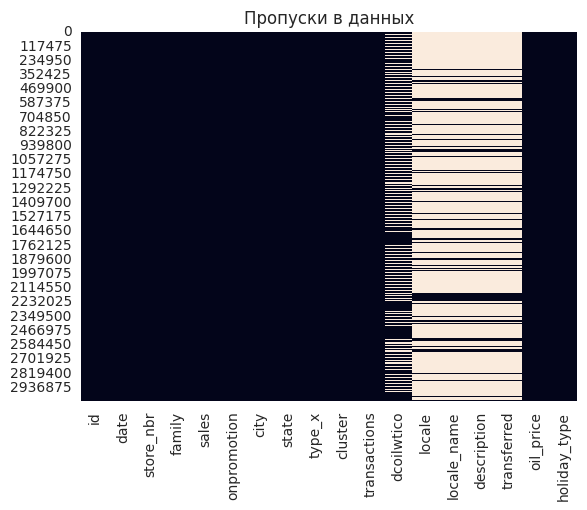

In [46]:
print(train.isnull().sum())

sns.heatmap(train.isnull(), cbar=False)
plt.title('Пропуски в данных')
plt.show()

In [48]:
train = train_df.merge(stores_df, on='store_nbr', how='left')
train = train.merge(transactions_df, on=['date', 'store_nbr'], how='left')
train = train.merge(oil_df, on='date', how='left')
train = train.merge(holidays_df, on='date', how='left')

train['oil_price'] = train['dcoilwtico'].ffill().bfill()
train['holiday_type'] = train['type_y'].fillna('No Holiday')
train['transactions'] = train['transactions'].ffill()
train.drop(columns=['type_y'], inplace=True)

train['store_nbr'] = train['store_nbr'].astype(str)
train['cluster'] = train['cluster'].astype(str)

# Создание временных признаков
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day_of_week'] = train['date'].dt.dayofweek
train['week_of_year'] = train['date'].dt.isocalendar().week
train['is_weekend'] = train['day_of_week'].isin([5, 6]).astype(int)
train['is_holiday'] = (train['holiday_type'] != 'Work Day').astype(int)

# Лаговые и скользящие средние признаки
train['lag_7_sales'] = train['sales'].shift(7)
train['lag_14_sales'] = train['sales'].shift(14)
train['rolling_mean_7'] = train['sales'].shift(1).rolling(window=7).mean()
train['rolling_mean_14'] = train['sales'].shift(1).rolling(window=14).mean()

In [50]:
# Удаление строк с пропущенными значениями
train = train.dropna(subset=['lag_7_sales', 'lag_14_sales', 'rolling_mean_7', 'rolling_mean_14'])

# Лог-трансформация целевой переменной
train['log_sales'] = np.log1p(train['sales'])

test = test_df.merge(stores_df, on='store_nbr', how='left')
test = test.merge(transactions_df, on=['date', 'store_nbr'], how='left')
test = test.merge(oil_df, on='date', how='left')
test = test.merge(holidays_df, on='date', how='left')

test['oil_price'] = test['dcoilwtico'].ffill().bfill()
test['holiday_type'] = test['type_y'].fillna('No Holiday')
test['transactions'] = test['transactions'].ffill()
test.drop(columns=['type_y'], inplace=True)

test['store_nbr'] = test['store_nbr'].astype(str)
test['cluster'] = test['cluster'].astype(str)


test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day_of_week'] = test['date'].dt.dayofweek
test['week_of_year'] = test['date'].dt.isocalendar().week
test['is_weekend'] = test['day_of_week'].isin([5, 6]).astype(int)
test['is_holiday'] = (test['holiday_type'] != 'Work Day').astype(int)

# Лаговые и скользящие средние признаки в test
last_lag_7_sales = train['lag_7_sales'].iloc[-1]
last_lag_14_sales = train['lag_14_sales'].iloc[-1]
last_rolling_mean_7 = train['rolling_mean_7'].iloc[-1]
last_rolling_mean_14 = train['rolling_mean_14'].iloc[-1]

test['lag_7_sales'] = last_lag_7_sales
test['lag_14_sales'] = last_lag_14_sales
test['rolling_mean_7'] = last_rolling_mean_7
test['rolling_mean_14'] = last_rolling_mean_14


# Удаление строк с пропущенными значениями
test = test.dropna(subset=['lag_7_sales', 'lag_14_sales', 'rolling_mean_7', 'rolling_mean_14'])

In [51]:
# Разделение train на признаки и целевую переменную
X = train.drop(columns=['sales', 'log_sales'])
y = train['log_sales']

categorical_features = ['holiday_type', 'locale', 'locale_name', 'store_nbr', 'family', 'city', 'state', 'cluster']
numerical_features = ['onpromotion', 'transactions', 'oil_price', 'lag_7_sales', 'lag_14_sales', 'rolling_mean_7', 'rolling_mean_14']

In [ ]:
from optuna.integration import XGBoostPruningCallback

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Функция для Optuna
def objective(trial):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'device': 'cuda',
        'random_state': 42
    }

    tscv = TimeSeriesSplit(n_splits=7)
    rmsle_scores = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        target_encoder = ce.TargetEncoder(cols=categorical_features)
        X_train_encoded = target_encoder.fit_transform(X_train, y_train)
        X_test_encoded = target_encoder.transform(X_test)

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_features),
                ('cat', 'passthrough', categorical_features)
            ]
        )

        X_train_processed = preprocessor.fit_transform(X_train_encoded)
        X_test_processed = preprocessor.transform(X_test_encoded)

        dtrain = xgb.DMatrix(X_train_processed, label=y_train)
        dtest = xgb.DMatrix(X_test_processed, label=y_test)

        # Обучение модели с ранней остановкой
        model = xgb.train(
            param, 
            dtrain,
            num_boost_round=trial.suggest_int('n_estimators', 100, 1000),
            evals=[(dtest, 'validation')],
            early_stopping_rounds=15,
            verbose_eval=False,
        )

        # Предсказание
        y_pred = model.predict(dtest)
        y_pred = np.maximum(0, y_pred)

        # Применение RMSLE
        rmsle = mean_squared_log_error(y_test, y_pred, squared=False)
        rmsle_scores.append(rmsle)
        
    return sum(rmsle_scores) / len(rmsle_scores)

# Запуск Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print(f"  RMSLE: {trial.value}")
print("  Best hyperparameters: ", trial.params)

In [ ]:
import joblib
os.makedirs("notebook_output", exist_ok=True)
model_path = "notebook_output/trained_xgb.pkl"
joblib.dump((final_model, final_target_encoder, final_preprocessor), model_path)

print(f"Model saved to {model_path}")